# Estudio de Ascenso de Gradientes con una distribución Benoulli

En este estudio vamos a utilizar una distribución Bernoulli, en la que, básicamente, un brazo sólo puede dar dos resultados, de éxito, 1, o de fracaso, 0.

In [9]:
import sys

# Añadir los directorios fuentes al path de Python
sys.path.append('./src/')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm
from algorithms.softmax import Softmax
from arms.armbernoulli import ArmBernoulli
from arms import Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml', '', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32\\lib', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\Pythonwin', './src/', './src/']


In [10]:
seed = 42
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    optimal_reward = bandit.get_expected_value(optimal_arm) # Recompensa esperada del brazo óptimo.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz del rechazo acumulado

    arm_stats = [(algo, {arm: [0, 0] for arm in range(len(bandit.arms))}) for algo in algorithms] # TODO: Lista para almacenar estadísticas por cada algoritmo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        cumulative_regret = np.zeros(len(algorithms))   # Acumulador de rechazo acumulado por algoritmo.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # TODO: (arm_statistics) Buscar el conjunto de estadísticas correspondiente a este algoritmo
                _, stats = arm_stats[idx]
                # Registrar selecciones y recompensas en arm_stats
                stats[chosen_arm][0] += 1  # Contador de selecciones
                stats[chosen_arm][1] += reward  # Suma de recompensas

                #TODO: (optimal_selections) modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del rechazo
                regret = optimal_reward - reward  
                cumulative_regret[idx] += regret  # Acumular regret total
                regret_accumulated[idx, step] += cumulative_regret[idx] 


    rewards /= runs

    # TODO: (optimal_selections) calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    regret_accumulated /= runs  # Calcular el rechazo acumulado promedio

    # TODO: (arm_statistics) Calcular la recompensa promedio para cada brazo
    for _, stats in arm_stats:
        for arm in stats:
            selections, total_reward = stats[arm]
            stats[arm] = (selections, total_reward / selections if selections > 0 else 0)

    return rewards, optimal_selections, arm_stats, regret_accumulated

## Softmax

Para este algoritmo, vamos a utilizar su parámetro τ, que controla el equilibrio entre exploración y explotación.
- Si τ es grande, todos los brazos tienen probabilidades similares para ser elegidos, lo que promueve la exploración.
- Si τ es pequeña, el brazo con mayor recompensa estimada se elige con mayor probabilidad, lo que prioriza la explotación.
- Si τ es 0, el algoritmo se comporta como un greedy puro, escogiendo siempre el mejor brazo estimado (pura explotación).

In [22]:

# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
softmax_algorithms = [Softmax(k=k, temperature=0.1), Softmax(k=k, temperature=0.5), Softmax(k=k, temperature=2)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, softmax_algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.39963209507789), ArmBernoulli(p=0.8605714451279329), ArmBernoulli(p=0.685595153449124), ArmBernoulli(p=0.5789267873576293), ArmBernoulli(p=0.22481491235394924), ArmBernoulli(p=0.22479561626896213), ArmBernoulli(p=0.14646688973455957), ArmBernoulli(p=0.7929409166199481), ArmBernoulli(p=0.5808920093945671), ArmBernoulli(p=0.6664580622368363)
Optimal arm: 2 with expected reward=0.8605714451279329


### Recompensa promedio

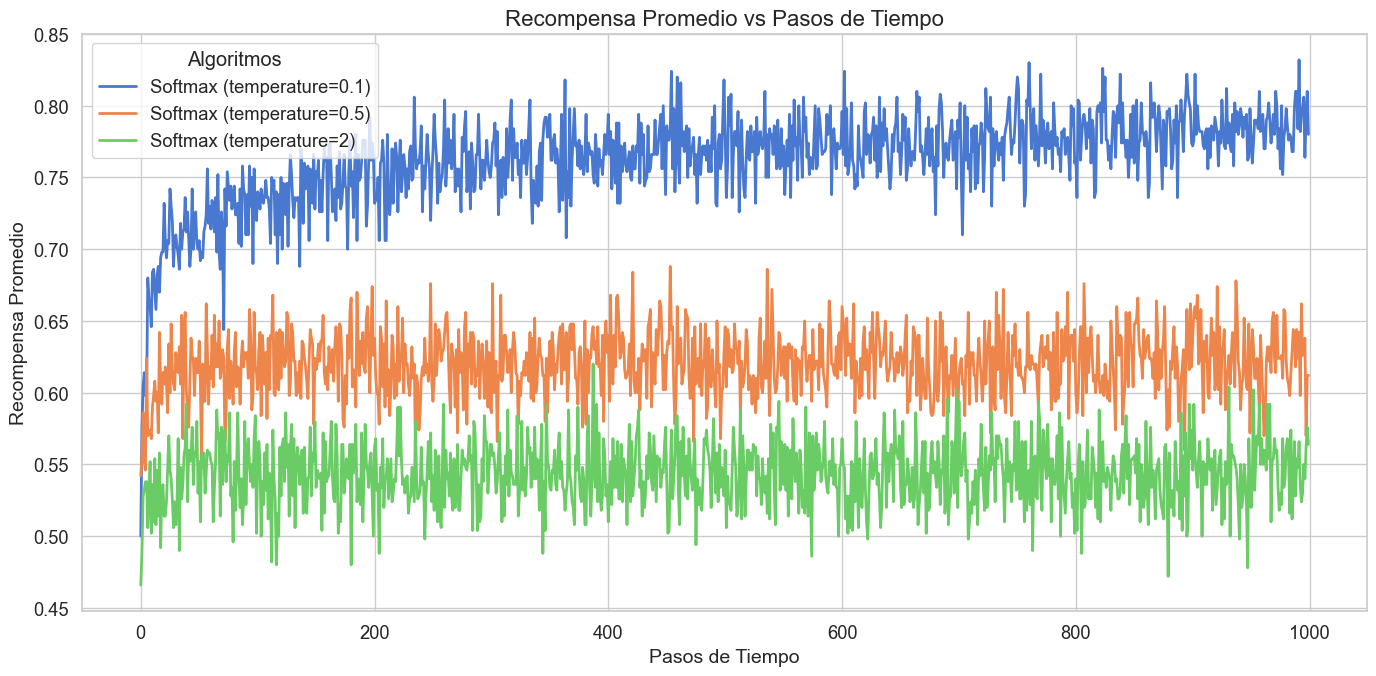

In [23]:
plot_average_rewards(steps, rewards, softmax_algorithms)

Como se puede observar, el que mejor recompensa promedio obtiene es el algoritmo en el que τ = 0.1, ya que se enfoca en explotar los brazos que ya tienen recompensas altas.

Para τ = 0.5, el algoritmo se centra en obtener un equilibrio entre exploración y explotación, lo que hace que sea menos eficiente en la explotación que el primer algoritmo y se obtengan peores resultados en la recompensa promedio.

Para τ = 2, la explotación es excesiva, y el agente prioriza probar nuevos brazos en los que la recompensa es baja, por ello se debe a que sea el peor en este aspecto.

### Rechazo acumulado

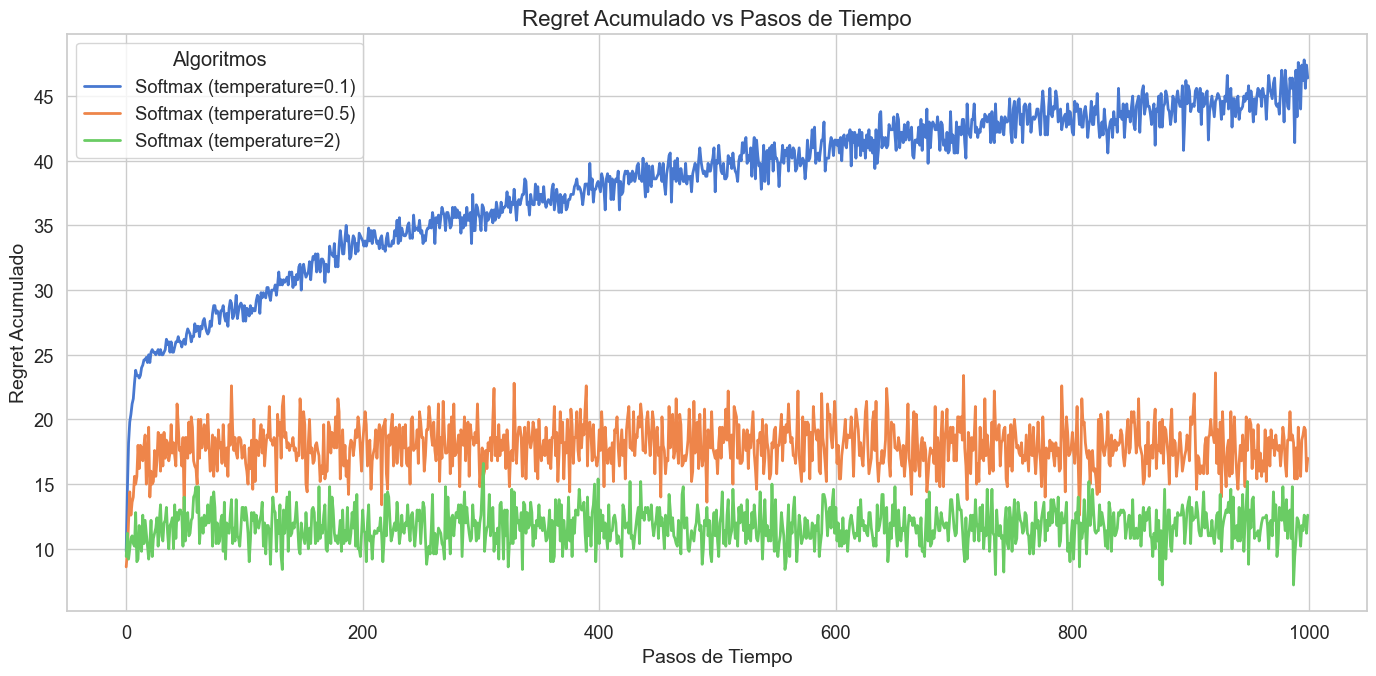

In [25]:
plot_regret(steps, optimal_selections, softmax_algorithms)

Lo primero a comentar es que el algoritmo que más rechazo obtiene es en el que τ = 1, ya que, al priorizar la explotación, el agente nunca se toma el tiempo de explorar los otros brazos lo suficiente, lo que le lleva a rechazar opciones que pueden ser mejores. Además, el crecimiento del rechazo tiene una tendencia constante, ya que suele escoger los mismos brazos al no explorar mucho, acumulando siempre el mismo rechazo.

Para τ = 0.5, se observa que el rechazo es bastante menor que en el anterior algoritmo, ya que la exploración le permite descubrir mejores opciones o evitar el sobreajuste a un brazo inicialmente subóptimo, como creemos que ocurre en el primer algoritmo.

Para τ = 2, a pesar de aumentar su aleatoriedad, el rechazo acumulado disminuye.

Parece que, cuanto mayor es el factor de exploración para Softmax, menor es el rechazo acumulado obtenido, pero también es menor la recompensa promedio.

